In [174]:
import pandas as pd
import numpy as np

Read data

In [175]:
df = pd.read_csv('data/project_mens_train_file.csv')

FileNotFoundError: [Errno 2] File data/project_mens_train_file.csv does not exist: 'data/project_mens_train_file.csv'

Quick preprocessing steps for column names; replace . with _ for better working with columns in Python. 

In [159]:
columns_list = df.columns
new_cols = [i.replace('.', '_') for i in columns_list]
df = df.rename(dict(zip(columns_list, new_cols)), axis=1)
df = df.drop(['train', 'id'], axis=1)

# Data Exploration

Use the amazing pandas profiling library in order to get a feel for the data. 

In [160]:
from pandas_profiling import ProfileReport
profile = ProfileReport(df, title='Pandas Profiling Report', explorative=True)

In [161]:
# profile

---

# Correlation
Determine correlation between features and target classes. Specifically look at which features are highly correlated to outcome

### Correlation Preprocessing

In [162]:
import matplotlib.pyplot as plt
import seaborn as sns

In [171]:
# map target class to something more meaningful
def map_outcome_to_binary_names(word):
    if word == 'UE':
        return 'is_unforced_error'
    if word == 'FE':
        return 'is_forced_error'
    if word == 'W':
        return 'is_winner'

In [165]:
# put mapping in label name variable
df['label_name'] = df['outcome'].apply(lambda x: map_outcome_to_binary_names(x))

In [166]:
# create  binary labels and join into original df
dummy_labels = pd.Series(df['label_name']).str.get_dummies()
df = df.join(dummy_labels)

### Correlation Visualisation

In [172]:
# determine columns which I want to visualise; only visualise numeric variables
columns_to_visualise = list(
    pd.DataFrame(df.dtypes) # determine types of df
    .rename({0: 'type'}, axis=1) # rename column to type
    .query('type != "object"') # get all non-string columns (meaning numeric)
    .index # get the name of the column
) 

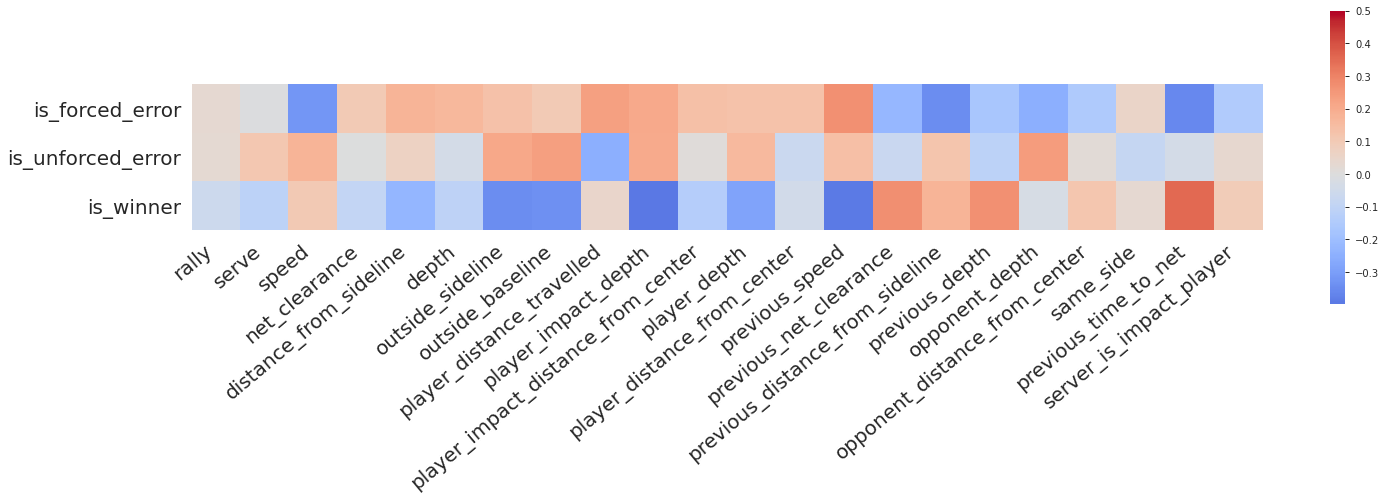

In [173]:
remove_vars = ['serve']
response_vars = ['is_forced_error', 'is_unforced_error', 'is_winner']


corrmat = df[columns_to_visualise].corr()
f, ax = plt.subplots(figsize=(24, 18))
heatmap = sns.heatmap(
    corrmat.loc[~corrmat.index.isin(response_vars),
                response_vars].T, 
    vmax=0.5, square=True, center = 0,
    cbar_kws={'shrink': 0.3},
    cmap='coolwarm')
heatmap.set_xticklabels(heatmap.get_xticklabels(),
                        rotation=40, fontsize=20, 
                        ha='right')
heatmap.set_yticklabels(heatmap.get_yticklabels(), 
                        rotation=0, fontsize=20)
plt.show()

**Intepretation**: This is very insightful. Squares towards blue colors indicate that features are negatively correlated with our target classes. Squares towards red highlight positively correlated features with target classes. The stronger the colours, the higher the positive/negative correlation. This already gives an indication of what makes up a each target class. Here are my takeaways from this:
- Forced errors: 
    - Low speed of current shot
    - High speed of previous shot
    - Low distance from sideline of previous shot
    - Low time for previous shot to pass the net
- Unforced errors: 
    - High speed, landing outside side and base line
    - Low distance of player travelled
    - High distance of opponent from net for previous shot
- Winner
    - Medium-high speed
    - Low distance from sidelines
    - Negative correlation of outside sideline and baseline (meaning shot is in)
    - Low distance from net when making winner
    - Low previous speed
    - High net clearance
    - High distance from opponent from net
    - Long previous time to net
    
Additionally, what we can take from this is that it will be relatively easy for the algorithm to classify a winner vs forced/unforced error. The becomes clear when looking at the correlation colours. One can observe that correlations for winners vs. forced/unforced errors are in contrary directions (e.g. if positive for winner, then negative for forced/unforced errors.